In [1]:
from fastai.vision.all import *
import cv2

In [2]:
def dark_channel(image,kernel_size):
    #split by channels
    b,g,r = cv2.split(image)
    #finding minimums between all 3 channels
    dark_channel = cv2.min(cv2.min(r,g),b)
    #getting our kernel
    s = (kernel_size, kernel_size)
    kernel = np.ones(s).astype(int)
    #erosion
    res = cv2.erode(dark_channel,kernel)
    return res

In [3]:
img = cv2.imread('haze.png')

In [4]:
dark = dark_channel(img, 15)

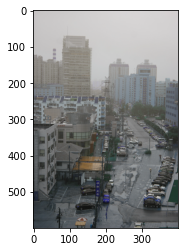

In [5]:
plt.imshow(img)

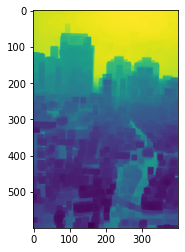

In [6]:
plt.imshow(dark)

In [7]:
def Atmospheric_light(img,dark):
    size = img.shape[0]*img.shape[1]
    #print(size)
    #choose only 0,1% of the most bright pixels
    zeroonepercent = int(max(math.floor(size/1000),1))
    darkvec = dark.reshape(size,1)
    #print('before:', dark.shape, 'after:', darkvec.shape)
    imgvec = img.reshape(size,3)
    #print('before:', img.shape, 'after:', imgvec.shape)
    indices = darkvec.argsort()
    indices = indices[size-zeroonepercent::]
    #print(indices.shape)
    Ac = np.zeros([1,3])
    #summing over all 0,1% brightest pixels
    for i in range(1,zeroonepercent):
        Ac = Ac + imgvec[indices[i]]
        #print(Ac)
    #Taking final average
    Ac = Ac / zeroonepercent;
    return Ac

In [8]:
Atmospheric_light(img, dark) #Получили нашу серость

array([[195.18333333, 192.19583333, 194.1875    ]])

(1, 3)


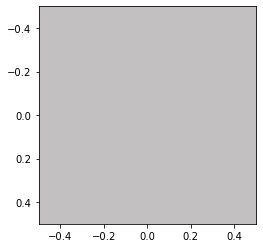

In [9]:
#Вот она прекрасная
atm = Atmospheric_light(img, dark)
atm = atm.astype('int')
print(atm.shape)
atm = atm.reshape(1,1,3)
plt.imshow(atm)

In [10]:
def transmission_map(img,atm,kernel_size,omega):
    im_array = np.zeros(img.shape,img.dtype)
    #print(im_array)
    #Делим значения в каждом канале картинки на полученные атмосферные параметры
    for i in range(0,3):
        im_array[:,:,i] = img[:,:,i]/atm[0,i]
    #Считаем светопередачу по формуле
    t = 1 - omega*dark_channel(im_array,kernel_size)
    return t

In [11]:
atm = Atmospheric_light(img, dark)

In [12]:
transmission_est = transmission_map(img,atm,15,0.75)

In [13]:
def guideFilter(I, p, r, eps):
    #I's mean smoothing
    mean_I = cv2.blur(I, (r,r))
    #p's mean smoothing
    mean_p = cv2.blur(p, (r,r))
    #Mean smoothing of I*I and I*p
    mean_II = cv2.blur(I*I, (r,r))
    mean_Ip = cv2.blur(I*p, (r,r))
    #variance
    var_I = mean_II - mean_I * mean_I #Variance formula
    #Covariance
    cov_Ip = mean_Ip - mean_I * mean_p
    
    a = cov_Ip / (var_I + eps)
    b = mean_p - a*mean_I
    #Mean smoothing of a and b
    mean_a = cv2.blur(a, (r,r))
    mean_b = cv2.blur(b, (r,r))
    
    q = mean_a*I + mean_b
    return q

In [14]:
pivo = cv2.imread('newpivo.jpg', cv2.IMREAD_ANYCOLOR)

In [15]:
#Let's look at how filter works
image_0_1 = pivo/255
b, g, r = cv2.split(image_0_1)
channel1 = guideFilter(b, b, 15, 0.01)
channel2 = guideFilter(g, g, 15,  0.01)
channel3 = guideFilter(r, r, 15,  0.01)
filteredpivo = cv2.merge([channel1, channel2, channel3])

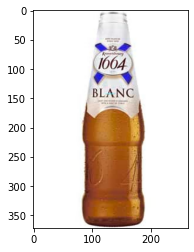

In [16]:
plt.imshow(pivo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


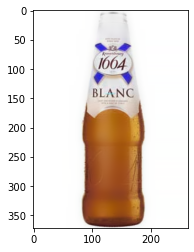

In [17]:
plt.imshow(filteredpivo)

In [18]:
def Refine(img,transmission_est):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray)/255
    r = 20
    eps = 0.0001
    t = guideFilter(gray,transmission_est,r,eps)
    return t

In [19]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

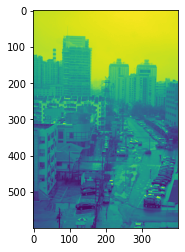

In [20]:
plt.imshow(gray)

In [21]:
image_0_1 = img/255
b, g, r = cv2.split(image_0_1)
channel1 = guideFilter(b, b, 15, 0.01)
channel2 = guideFilter(g, g, 15,  0.01)
channel3 = guideFilter(r, r, 15,  0.01)
filteredimg = cv2.merge([channel1, channel2, channel3])

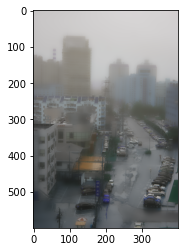

In [22]:
plt.imshow(filteredimg)

In [23]:
#4.3. Recovering the Scene Radiance
#A typical value of t0 is 0.1
def unhaze(img,t,A,t0 = 0.1):
    new_img = np.empty(img.shape,img.dtype)
    t = cv2.max(t,t0)
    for i in range(0,3):
        new_img[:,:,i] = (img[:,:,i]-A[0,i])/t + A[0,i]
    return new_img

In [24]:
def bgr2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [25]:
img = cv2.imread('haze.png')
I = img.astype('float64')/255
dark = dark_channel(I,15)
atm = Atmospheric_light(I,dark)
trans = transmission_map(I,atm,15, 0.75)
filtered = Refine(img,trans)
J = unhaze(I,filtered,atm,0.1)

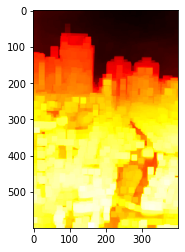

In [26]:
plt.imshow(trans, cmap = 'hot')

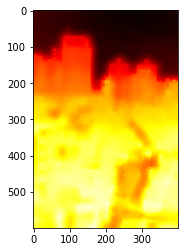

In [27]:
plt.imshow(filtered, cmap = 'hot')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


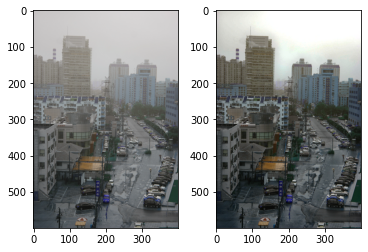

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(I)
ax2.imshow(J)

In [29]:
img = cv2.imread('haze_8.jpg')
img = bgr2rgb(img)
I = img.astype('float64')/255
dark = dark_channel(I,15)
atm = Atmospheric_light(I,dark)
trans = transmission_map(I,atm,15, 0.75)
filtered = Refine(img,trans)
J = unhaze(I,filtered,atm,0.1)

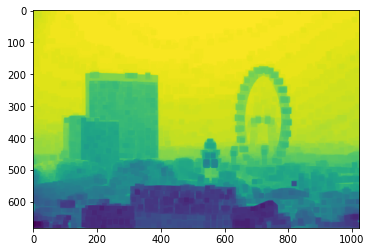

In [30]:
plt.imshow(dark)

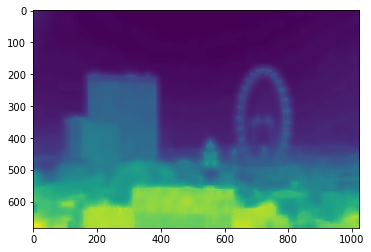

In [31]:
plt.imshow(filtered )

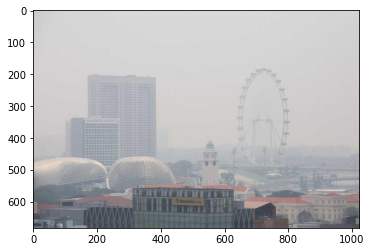

In [32]:
plt.imshow(I)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


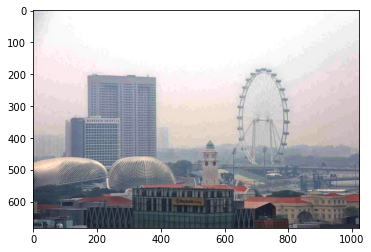

In [33]:
plt.imshow(J)

In [34]:
img = cv2.imread('china.png')
img = bgr2rgb(img)
I = img.astype('float64')/255
dark = dark_channel(I,15)
atm = Atmospheric_light(I,dark)
trans = transmission_map(I,atm,15, 0.75)
filtered = Refine(img,trans)
J = unhaze(I,filtered,atm,0.1)

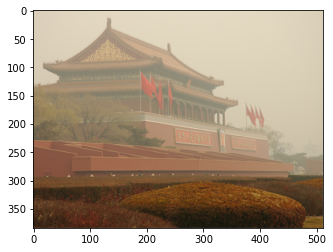

In [35]:
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


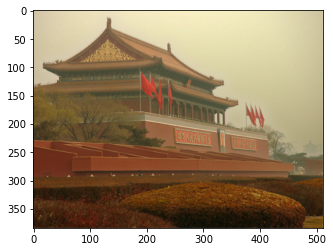

In [36]:
plt.imshow(J)